Dénes Csala, MCC, Kolozsvár, 2021  
<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Clustering: K-Means In-Depth

Here we'll explore **K Means Clustering**, which is an unsupervised clustering technique.

We'll start with our standard set of initial imports

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use("seaborn")

## Introducing K-Means

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

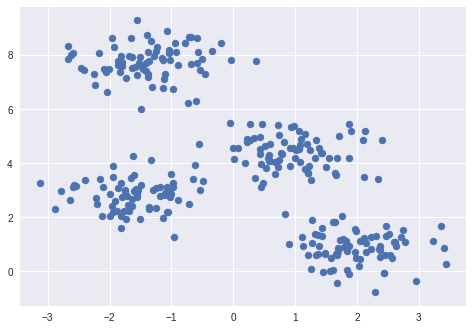

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

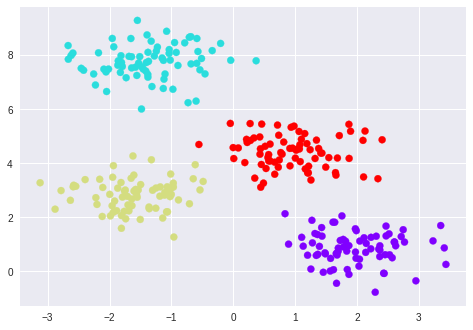

In [7]:
from sklearn.cluster import KMeans

est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap="rainbow");

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
   A. Assign points to the nearest cluster center
   B. Set the cluster centers to the mean 
   
Let's quickly visualize this process:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [15]:
def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    from ipywidgets import interact
    from sklearn.metrics.pairwise import euclidean_distances
    from sklearn.datasets import make_blobs

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')

        X, y = make_blobs(n_samples=300, centers=8,
                          cluster_std=2)

        def _kmeans_step(frame=0, n_clusters=4):
            rng = np.random.RandomState(2)
            labels = np.zeros(X.shape[0])
            centers = rng.randn(n_clusters, 2)

            nsteps = frame // 3

            for i in range(nsteps + 1):
                old_centers = centers
                if i < nsteps or frame % 3 > 0:
                    dist = euclidean_distances(X, centers)
                    labels = dist.argmin(1)

                if i < nsteps or frame % 3 > 1:
                    centers = np.array([X[labels == j].mean(0)
                                        for j in range(n_clusters)])
                    nans = np.isnan(centers)
                    centers[nans] = old_centers[nans]


            # plot the data and cluster centers
            plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow',
                        vmin=0, vmax=n_clusters - 1);
            plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                        c=np.arange(n_clusters),
                        s=200, cmap='rainbow')
            plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                        c='black', s=50)

            # plot new centers if third frame
            if frame % 3 == 2:
                for i in range(n_clusters):
                    plt.annotate('', centers[i], old_centers[i], 
                                 arrowprops=dict(arrowstyle='->', linewidth=1))
                plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c=np.arange(n_clusters),
                            s=200, cmap='rainbow')
                plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c='black', s=50)

#             plt.xlim(-4, 4)
#             plt.ylim(-2, 10)

            if frame % 3 == 1:
                plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                         ha='right', va='top', size=14)
            elif frame % 3 == 2:
                plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                         ha='right', va='top', size=14)

    
    return interact(_kmeans_step, frame=(0, 50),
                    n_clusters=range(min_clusters, max_clusters+1))

In [17]:
plot_kmeans_interactive();

interactive(children=(IntSlider(value=0, description='frame', max=50), Dropdown(description='n_clusters', inde…

This algorithm will (often) converge to the optimal cluster centers.

### KMeans Caveats

The convergence of this algorithm is not guaranteed; for that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand... there are other clustering algorithms for which this requirement may be lifted.

In [18]:
# DBSCAN
# GMM

## Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [19]:
from sklearn.datasets import load_digits

digits = load_digits()

In [20]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

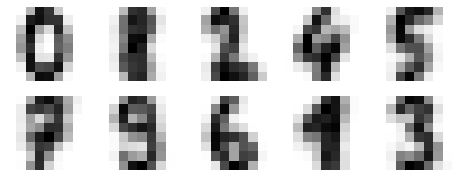

In [21]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

The cluster labels are permuted; let's fix this:

In [22]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = clusters == i
    labels[mask] = mode(digits.target[mask])[0]

For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

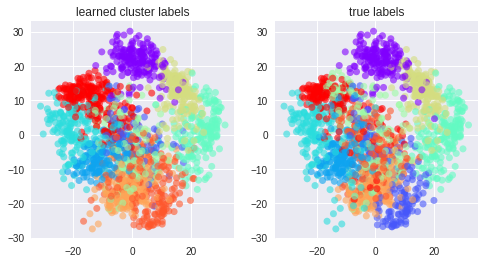

In [23]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap=plt.cm.get_cmap("rainbow", 10), edgecolor="none", alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title("learned cluster labels")

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title("true labels");

Just for kicks, let's see how accurate our K-Means classifier is **with no label information:**

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score(digits.target, labels)

0.7929883138564274

80% – not bad! Let's check-out the confusion matrix for this:

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   0 154   0   2   0   7   7  13]
 [  0   5   0   0 164   0   0   9   3   0]
 [  0   0   0   1   2 136   1   0   0  42]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   0   0 175   2   0]
 [  0   6   3   2   0   4   2   5 100  52]
 [  0  20   0   6   0   6   0   7   2 139]]


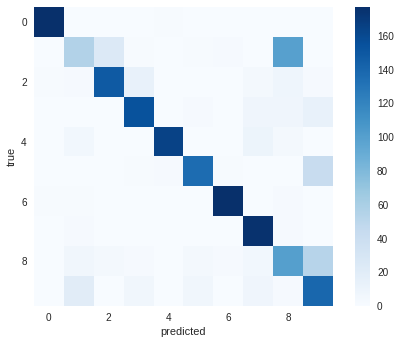

In [25]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(digits.target, labels))

plt.imshow(
    confusion_matrix(digits.target, labels), cmap="Blues", interpolation="nearest"
)
plt.colorbar()
plt.grid(False)
plt.ylabel("true")
plt.xlabel("predicted");

Again, this is an 80% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

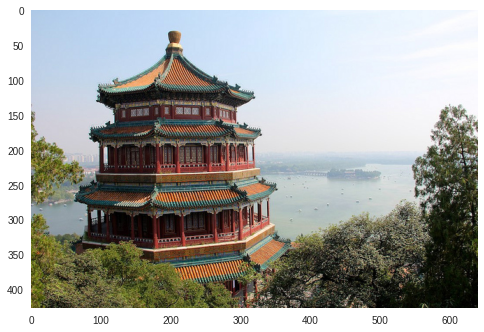

In [26]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [27]:
256 ** 3

16777216

In [28]:
china[0][0]

array([174, 201, 231], dtype=uint8)

In [29]:
china.shape

(427, 640, 3)

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [30]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

Here we'll use ``MiniBatchKMeans``, a more sophisticated estimator that performs better for larger datasets:

In [31]:
from sklearn.cluster import MiniBatchKMeans

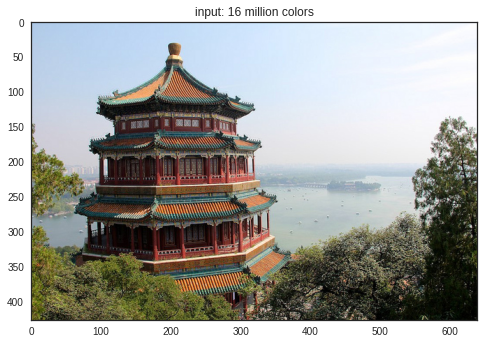

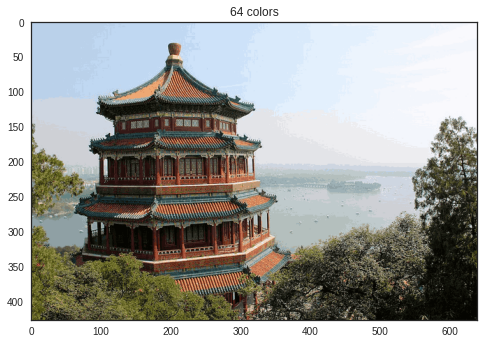

In [32]:
# reduce the size of the image for speed
n_colors = 64

X = (china / 255.0).reshape(-1, 3)

model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with plt.style.context("seaborn-white"):
    plt.figure()
    plt.imshow(china)
    plt.title("input: 16 million colors")

    plt.figure()
    plt.imshow(new_image)
    plt.title("{0} colors".format(n_colors))

Compare the input and output image: we've reduced the $256^3$ colors to just 64.

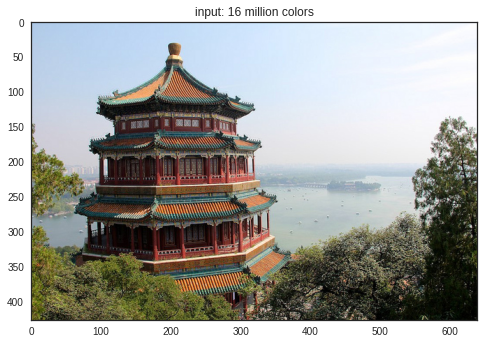

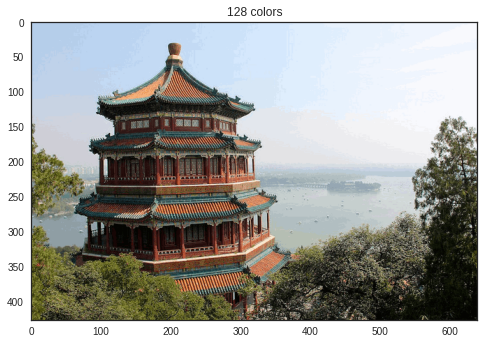

In [33]:
# reduce the size of the image for speed
n_colors = 128

X = (china / 255.0).reshape(-1, 3)

model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with plt.style.context("seaborn-white"):
    plt.figure()
    plt.imshow(china)
    plt.title("input: 16 million colors")

    plt.figure()
    plt.imshow(new_image)
    plt.title("{0} colors".format(n_colors))